## `Social Media Analysis`

### `import libraries`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msg
from datasist.structdata import detect_outliers
import os 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn_features.transformers import DataFrameSelector

### `Load Data`

In [2]:
file_path=os.path.join(os.getcwd(),"social_media_data.csv")

In [3]:
df=pd.read_csv(file_path)

In [4]:
df.head()

,date,platform,post_type,likes,shares,comments,views
0,2023-05-24,Twitter,image,868.0,238.0,352.0,8836.0
1,2023-02-23,Twitter,image,944.0,610.0,146.0,5554.0
2,2023-03-18,Instagram,image,1067.0,858.0,365.0,4018.0
3,2023-06-12,Twitter,text,780.0,427.0,100.0,6999.0
4,2023-02-03,Instagram,text,836.0,893.0,443.0,5802.0


## Dataset

The dataset contains the following columns:

- `date`: The date of the post (in YYYY-MM-DD format).
- `platform`: The social media platform where the post was made.
- `post_type`: The type of the post.
- `likes`: The number of likes the post received.
- `shares`: The number of shares the post received.
- `comments`: The number of comments on the post.
- `views`: The number of views the post received.

### `Distinguishing Attribute`

In [5]:
df.sample()

,date,platform,post_type,likes,shares,comments,views
1185,2023-04-13,Facebook,text,1448.0,539.0,251.0,8475.0


In [6]:
# check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       2000 non-null   object 
 1   platform   2000 non-null   object 
 2   post_type  2000 non-null   object 
 3   likes      1992 non-null   float64
 4   shares     1992 non-null   float64
 5   comments   1992 non-null   float64
 6   views      1990 non-null   float64
dtypes: float64(4), object(3)
memory usage: 109.5+ KB


In [7]:
df.describe()

,likes,shares,comments,views
count,1992.000000,1992.000000,1992.000000,1990.000000
mean,1289.795181,497.286647,305.847892,6966.834673
std,525.123426,229.809511,114.761598,1724.795879
min,400.000000,100.000000,100.000000,4000.000000
25%,820.000000,300.000000,206.000000,5507.000000
50%,1292.000000,491.000000,310.500000,6947.000000
75%,1753.250000,688.000000,407.000000,8398.250000
max,2200.000000,900.000000,500.000000,9998.000000


In [8]:
df.describe(include="object")

,date,platform,post_type
count,2000,2000,2000
unique,365,4,3
top,2023-02-13,Twitter,image
freq,12,685,735


### `Data Cleaning`

In [9]:
# date should be hanlded to date time 
df["date"]=pd.to_datetime(df["date"],errors="coerce",format="%Y-%m-%d")

In [10]:
#date changed --> done
df.dtypes

date         datetime64[ns]
platform             object
post_type            object
likes               float64
shares              float64
comments            float64
views               float64
dtype: object

In [11]:
# ckeck nulls
df.isna().sum().sort_values(ascending=False)

views        10
likes         8
shares        8
comments      8
date          0
platform      0
post_type     0
dtype: int64

In [12]:
df.isna().sum().sort_values(ascending=False)/df.shape[0]

views        0.005
likes        0.004
shares       0.004
comments     0.004
date         0.000
platform     0.000
post_type    0.000
dtype: float64

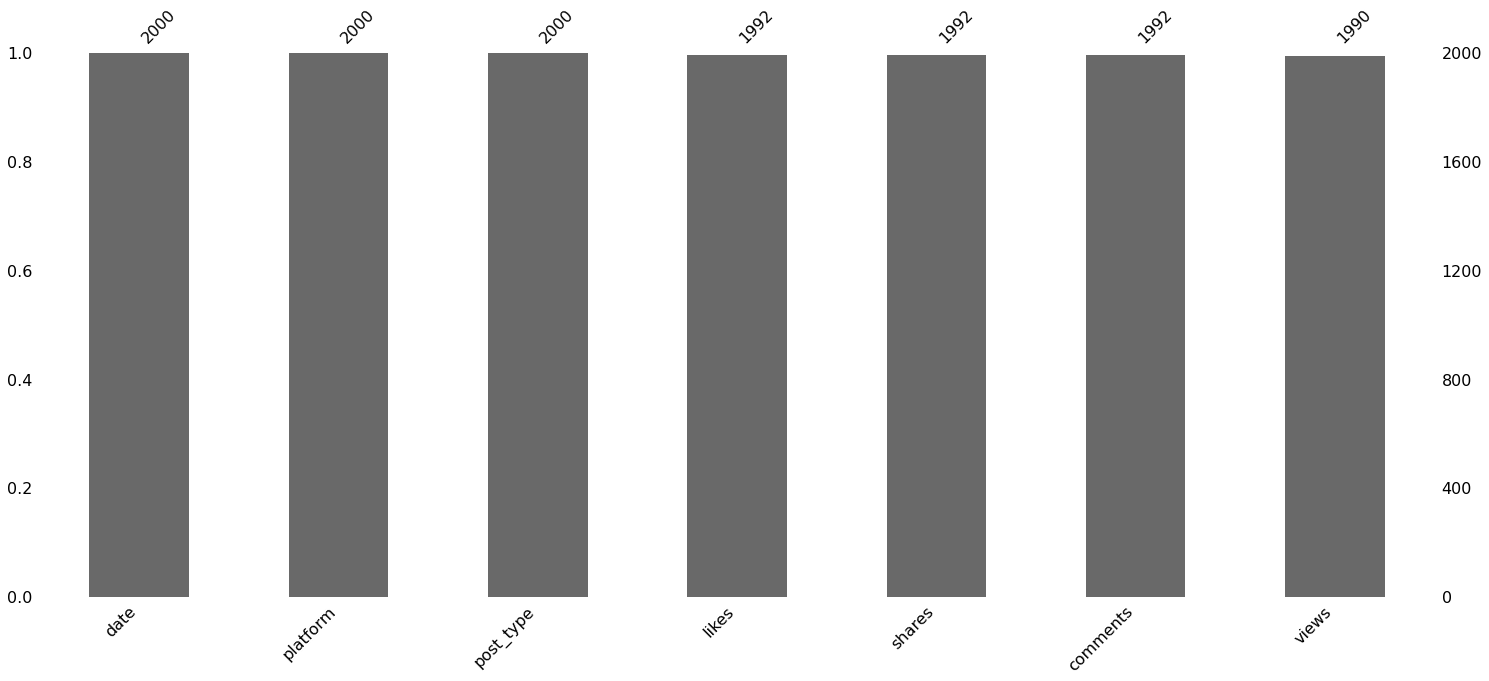

In [13]:
# missing_values
msg.bar(df);

In [14]:
num_cols=df.select_dtypes(include="number").columns.to_list()
cat_cols=df.select_dtypes(exclude="number").columns.to_list()

In [17]:
# impute numerical with mean ,caterogical with mode
num_pipe=Pipeline(steps=[
    ("selector",DataFrameSelector(num_cols)),
    ("num_impuer",SimpleImputer(strategy="mean"))
])
cat_pipe=Pipeline(steps=[
     ("selector",DataFrameSelector(cat_cols)),
    ("cat_impuer",SimpleImputer(strategy="most_frequent"))
 
])
all_pipe=FeatureUnion(transformer_list=[
    ("num_pipe",num_pipe),
    ("cat_impuer",cat_pipe)
])
df=pd.DataFrame(all_pipe.fit_transform(df),columns=num_cols+cat_cols)

In [18]:
df.isna().sum()

likes        0
shares       0
comments     0
views        0
date         0
platform     0
post_type    0
dtype: int64

In [19]:
# check duplicated
df.duplicated().sum()

0

In [23]:
# check_oultiers --> impute with medain
for col in num_cols:
    idx_outliers=detect_outliers(data=df,n=0,features=[col])
    #impute
    df.loc[idx_outliers,col]=df[col].mean()

### `EDA`

1. What was the total number of likes, shares, comments, and views (for videos) over the year?

In [24]:
df.head()

,likes,shares,comments,views,date,platform,post_type
0,868.0,238.0,352.0,8836.0,2023-05-24,Twitter,image
1,944.0,610.0,146.0,5554.0,2023-02-23,Twitter,image
2,1067.0,858.0,365.0,4018.0,2023-03-18,Instagram,image
3,780.0,427.0,100.0,6999.0,2023-06-12,Twitter,text
4,836.0,893.0,443.0,5802.0,2023-02-03,Instagram,text


In [25]:
# feature engineering
df["year"]=df["date"].dt.year

In [26]:
df["year"].unique()

array([2023, 2022], dtype=int64)

In [27]:
df["post_type"].unique()

array(['image', 'text', 'video'], dtype=object)

In [28]:
df_videos=df[df["post_type"]=='video']

In [29]:
df_videos.groupby(by="year")[["likes","shares","comments","views"]].agg("sum").sort_values(by="views",ascending=False)

,likes,shares,comments,views
year,,,,
2023,637898.590361,236994.85994,150778.543675,3.481740e+06
2022,180851.000000,75537.00000,44278.000000,1.017825e+06


2. Which platform had the highest engagement? (engagement = likes + shares + comments)

In [30]:
# feature engineering
df["engagement"]=df["likes"]+df["shares"]+df["comments"]

In [32]:
df.groupby(by="platform")[["engagement"]].agg("sum").sort_values(by="engagement",ascending=False).head(1)

,engagement
platform,
Instagram,1.426677e+06


In [47]:
df[df["product"]=="Smartphone"]

,price,quantity,revenue,date,product,category,year
0,600.0,10.0,6000.0,2022-01-01,Smartphone,Electronics,2022
6,600.0,8.0,4800.0,2022-01-06,Smartphone,Electronics,2022
13,600.0,12.0,7200.0,2022-01-12,Smartphone,Electronics,2022
18,600.0,6.0,3600.0,2022-01-17,Smartphone,Electronics,2022
23,600.0,7.0,4200.0,2022-01-22,Smartphone,Electronics,2022
...,...,...,...,...,...,...,...
348,600.0,12.0,7200.0,2022-12-11,Smartphone,Electronics,2022
352,600.0,6.0,3600.0,2022-12-15,Smartphone,Electronics,2022
358,600.0,7.0,4200.0,2022-12-21,Smartphone,Electronics,2022
363,600.0,9.0,5400.0,2022-12-26,Smartphone,Electronics,2022


3. What was the average number of likes, shares, comments, and views per post on each platform?

In [34]:
df.groupby(by="platform")[["likes","shares","comments","views"]].agg("mean").sort_values(by="views",ascending=False)

,likes,shares,comments,views
platform,,,,
Twitter,1275.015759,482.481129,305.857950,7013.054750
Facebook,1289.980944,513.091241,311.151898,6984.128904
Instagram,1305.789956,497.371898,301.081474,6906.145286
NonExistingPlatform,1150.166667,515.833333,285.500000,6729.166667


4. What was the total number of each type of post (video, image, text) on each platform?

In [63]:
pd.pivot_table(data=df,index="post_type",columns="platform",values="views",aggfunc=len)

platform,Facebook,Instagram,NonExistingPlatform,Twitter
post_type,,,,
image,218,267,1,249
text,204,203,3,219
video,209,208,2,217


5. Which type of post had the highest average engagement?

In [64]:
df.groupby(by="post_type")[["engagement"]].agg("mean").sort_values(by="engagement",ascending=False).head(1)

,engagement
post_type,
text,2128.903708


6. What was the total engagement in each quarter of the year?

In [65]:
# feature engineering
df["month"]=df["date"].dt.month

In [66]:
cut_quarters = ['Q1', "Q2", 'Q3', 'Q4']
cut_bins =[1, 3, 6, 9, 12]
df['quarters'] = pd.cut(df['month'], bins=cut_bins, labels =cut_quarters)

In [67]:
df.groupby(by="quarters")[["engagement"]].agg("sum").sort_values(by="engagement",ascending=False)

,engagement
quarters,
Q4,1.142293e+06
Q2,1.004266e+06
Q3,9.994032e+05
Q1,7.023651e+05
